# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.418478
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*
因为这里的系数矩阵W是随机初始化的，也就是说这些样本随机预测的话会有10%的准确率（10个类），0.1代表准确率是10%


In [12]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.242694 analytic: -0.877722, relative error: 5.667780e-01
numerical: -0.357605 analytic: 0.318806, relative error: 1.000000e+00
numerical: 1.482013 analytic: 1.268272, relative error: 7.771623e-02
numerical: -2.665121 analytic: -1.834278, relative error: 1.846565e-01
numerical: 2.937823 analytic: 1.879191, relative error: 2.197692e-01
numerical: -4.623071 analytic: -3.702089, relative error: 1.106263e-01
numerical: -2.003183 analytic: -2.197670, relative error: 4.629702e-02
numerical: -0.497985 analytic: -1.106475, relative error: 3.792496e-01
numerical: 0.758757 analytic: 0.483829, relative error: 2.212553e-01
numerical: 2.064987 analytic: 1.632916, relative error: 1.168422e-01
numerical: -2.477429 analytic: -1.809194, relative error: 1.558885e-01
numerical: -0.487780 analytic: -0.531616, relative error: 4.300163e-02
numerical: -2.563513 analytic: -2.615816, relative error: 1.009839e-02
numerical: 3.871194 analytic: 3.803868, relative error: 8.772024e-03
numerical: -2.022

In [15]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.418478e+00 computed in 0.102057s
vectorized loss: 2.418478e+00 computed in 0.015628s
Loss difference: 0.000000
Gradient difference: 0.000000


In [17]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
best_lr = None
best_reg = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
lr = learning_rates[0]
while lr <= learning_rates[1]:
    reg = regularization_strengths[0]
    while reg <= regularization_strengths[1]:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, 
                  num_iters=500, verbose=True)
        # （2）计算该模型在训练集和验证集上的准确率         
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        trainAccuracy = np.mean(y_train == y_train_pred)
        valAccuracy = np.mean(y_val == y_val_pred)
        # （3）把结果存在results中      
        results[(lr,reg)] = (trainAccuracy,valAccuracy)
        #（4）存储最好的valAccuracy和与之对应的svm模型
        if valAccuracy > best_val:
            best_val = valAccuracy
            best_softmax = softmax
        reg += 0.5e4
    lr += 1e-7
    
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 500: loss 771.033953
iteration 100 / 500: loss 472.840342
iteration 200 / 500: loss 324.473913
iteration 300 / 500: loss 263.351466
iteration 400 / 500: loss 248.410343
iteration 0 / 500: loss 936.046106
iteration 100 / 500: loss 517.695171
iteration 200 / 500: loss 321.218592
iteration 300 / 500: loss 244.421553
iteration 400 / 500: loss 226.760067
iteration 0 / 500: loss 1085.320332
iteration 100 / 500: loss 546.032681
iteration 200 / 500: loss 308.917396
iteration 300 / 500: loss 218.358492
iteration 400 / 500: loss 198.923891
iteration 0 / 500: loss 1236.869687
iteration 100 / 500: loss 563.483567
iteration 200 / 500: loss 300.337503
iteration 300 / 500: loss 214.839704
iteration 400 / 500: loss 197.816588
iteration 0 / 500: loss 1396.569342
iteration 100 / 500: loss 573.911793
iteration 200 / 500: loss 277.246965
iteration 300 / 500: loss 190.150403
iteration 400 / 500: loss 178.050298
iteration 0 / 500: loss 1526.186909
iteration 100 / 500: loss 572.452710
iteration

In [20]:
# evaluate on test set
# Evaluate the best softmax on test set
# 把上面得到的最好结果多迭代几次
best_softmax = Softmax()
best_softmax.train(X_train, y_train, learning_rate=5e-7, reg=5e4, 
                  num_iters=1500, verbose=True)
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

iteration 0 / 1500: loss 1525.168337
iteration 100 / 1500: loss 181.181824
iteration 200 / 1500: loss 208.877073
iteration 300 / 1500: loss 213.099068
iteration 400 / 1500: loss 215.682843
iteration 500 / 1500: loss 210.222102
iteration 600 / 1500: loss 214.130490
iteration 700 / 1500: loss 214.491695
iteration 800 / 1500: loss 215.659964
iteration 900 / 1500: loss 214.052247
iteration 1000 / 1500: loss 214.200775
iteration 1100 / 1500: loss 214.193207
iteration 1200 / 1500: loss 210.406812
iteration 1300 / 1500: loss 212.109133
iteration 1400 / 1500: loss 211.811289
softmax on raw pixels final test set accuracy: 0.160000


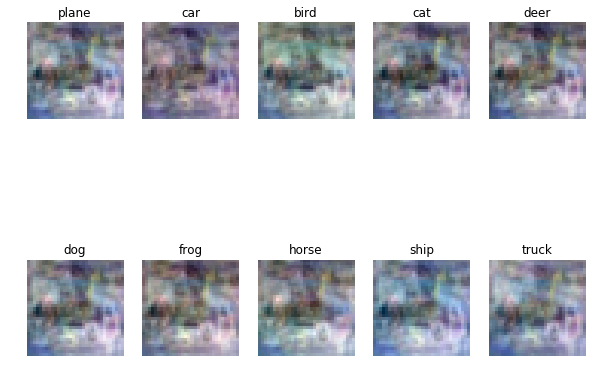

In [21]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])